In [11]:
import json

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input


class EmotionRecognitionTrainer:
    def __init__(self, img_height=48, img_width=48, batch_size=64):
        self.num_classes = None
        self.test_generator = None
        self.train_generator = None
        self.validation_generator = None
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.model = None
        self.history = None
        self.class_labels = None

    def setup_data_generators(self, train_dir, test_dir, validation_split=0.2):
        """Set up data generators with augmentation"""
        train_datagen = ImageDataGenerator(
            rescale=1. / 255,
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=validation_split
        )

        test_datagen = ImageDataGenerator(rescale=1. / 255)

        # Train generator
        self.train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            color_mode='grayscale',
            class_mode='categorical',
            subset='training',
            shuffle=True
        )

        # Validation generator
        self.validation_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            color_mode='grayscale',
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )

        # Test generator
        self.test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            color_mode='grayscale',
            class_mode='categorical',
            shuffle=False
        )

        self.class_labels = list(self.train_generator.class_indices.keys())
        self.num_classes = len(self.class_labels)

        print(f"Class labels: {self.class_labels}")
        print(f"Number of classes: {self.num_classes}")
        print(f"Training samples: {self.train_generator.samples}")
        print(f"Validation samples: {self.validation_generator.samples}")
        print(f"Test samples: {self.test_generator.samples}")

        return self.train_generator, self.validation_generator, self.test_generator

    def build_model(self):
        """Build CNN model for emotion recognition"""
        self.model = Sequential([
            # First Convolutional Block
            Input(shape=(self.img_height, self.img_width, 1)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            # Second Convolutional Block
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            # Third Convolutional Block
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            # Fourth Convolutional Block
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            # Classifier
            Flatten(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])

        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        print("Model compiled successfully!")
        self.model.summary()

    def train(self, epochs=100, patience=15):
        """Train the model with callbacks"""
        callbacks = [
            ModelCheckpoint(
                'best_emotion_model.keras',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=10,
                min_lr=1e-7,
                verbose=1
            )
        ]

        self.history = self.model.fit(
            self.train_generator,
            epochs=epochs,
            validation_data=self.validation_generator,
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def evaluate_model(self):
        """Evaluate the model on a test set"""
        # Load the best model
        best_model = load_model('best_emotion_model.keras')

        # Evaluate
        test_loss, test_accuracy = best_model.evaluate(self.test_generator, verbose=0)
        print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
        print(f"Test Loss: {test_loss:.4f}")

        # Predictions for a classification report
        y_pred = best_model.predict(self.test_generator, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = self.test_generator.classes

        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred_classes,
                                    target_names=self.class_labels))

        return test_accuracy, test_loss

    def plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            print("No training history available!")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy plot
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)

        # Loss plot
        ax2.plot(self.history.history['loss'], label='Training Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def save_class_labels(self, file_path='class_labels.json'):
        """Save class labels for inference"""
        with open(file_path, 'w') as f:
            json.dump(self.class_labels, f)
        print(f"Class labels saved to {file_path}")

In [12]:
trainer = EmotionRecognitionTrainer(img_height=48, img_width=48, batch_size=64)

# Setup data generators
train_dir = 'D:/Portfolio/DL Project/dataset/train'
test_dir = 'D:/Portfolio/DL Project/dataset/test'

trainer.setup_data_generators(train_dir, test_dir)

# Build and compile model
trainer.build_model()

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 7
Training samples: 22968
Validation samples: 5741
Test samples: 7178


<Sequential name=sequential_1, built=True>

In [13]:
trainer.compile_model(learning_rate=0.001)

Model compiled successfully!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,491,879 (9.51 MB)

 Trainable params: 2,488,423 (9.49 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [7]:
trainer.train(epochs=100, patience=15)

Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.1864 - loss: 2.5603
Epoch 1: val_accuracy improved from None to 0.25466, saving model to best_emotion_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 166s 445ms/step - accuracy: 0.2138 - loss: 2.2697 - val_accuracy: 0.2547 - val_loss: 1.9281 - learning_rate: 0.0010
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.2725 - loss: 1.8680
Epoch 2: val_accuracy improved from 0.25466 to 0.32555, saving model to best_emotion_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 159s 443ms/step - accuracy: 0.3005 - loss: 1.7985 - val_accuracy: 0.3256 - val_loss: 1.7412 - learning_rate: 0.0010
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.3696 - loss: 1.6362
Epoch 3: val_accuracy improved from 0.32555 to 0.34785, saving model to best_emotion_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 159s 441ms/step - accuracy: 0.3782 - loss: 1.6057 - val_accuracy: 0.3478 - val_loss: 1.7999 - learning_rate: 0.0010
Epoch 4/10

In [14]:
trainer.evaluate_model()


Test Accuracy: 67.07%
Test Loss: 0.9943

Classification Report:
              precision    recall  f1-score   support

       angry       0.56      0.65      0.61       958
     disgust       0.81      0.49      0.61       111
        fear       0.57      0.40      0.47      1024
       happy       0.89      0.86      0.87      1774
     neutral       0.59      0.70      0.64      1233
         sad       0.55      0.54      0.54      1247
    surprise       0.76      0.81      0.78       831

    accuracy                           0.67      7178
   macro avg       0.67      0.63      0.65      7178
weighted avg       0.67      0.67      0.67      7178



(0.6706603765487671, 0.9942567944526672)

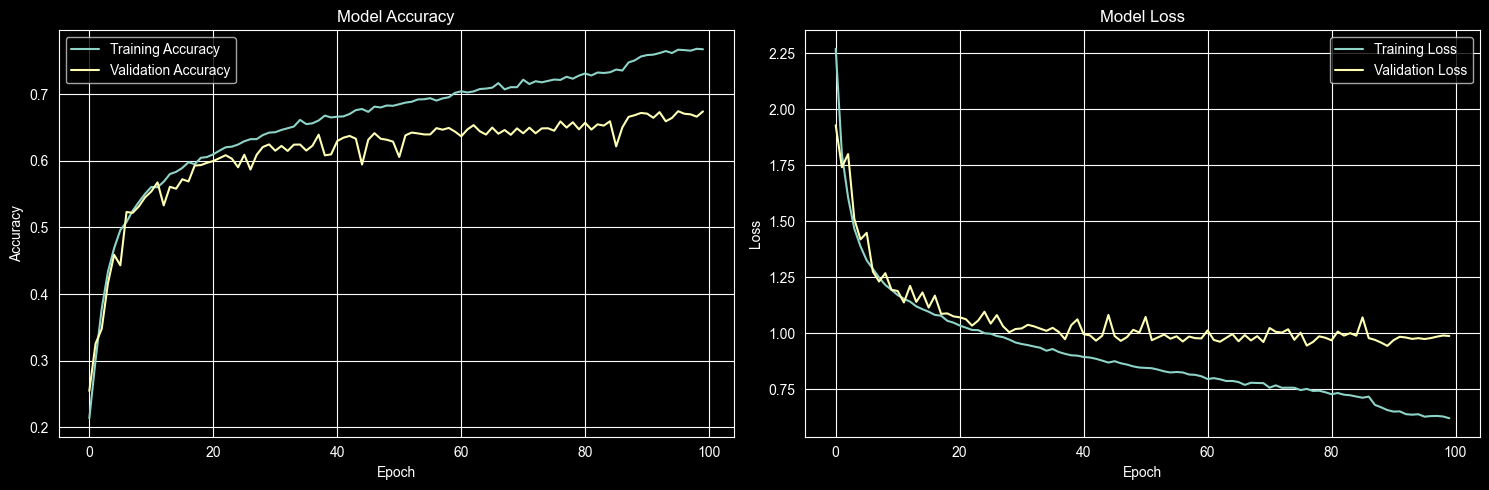

In [10]:
trainer.plot_training_history()

In [9]:
trainer.save_class_labels()

Class labels saved to class_labels.json
